## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested. 

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%): 
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [ ]:
# conda install -c pytorch torchtext
# conda install -c pytorch torchdata
# conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch
!pip install scikit-plot

In [17]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import scikitplot as skplt
import gc

In [18]:
# Use GPU if available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [19]:
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [20]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [21]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [22]:
#test tokens
tokens = tokeniser('Welcome to TE3007')
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


In [23]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [24]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [25]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [37]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))
    
    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int64), torch.tensor(y, dtype=torch.int64) - 1

In [38]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [39]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [76]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes, dropout=0.5):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), 
                                            embedding_dim=embed_size)
        
        self.rnn = nn.LSTM(embed_size, 2 * hidden, layers, batch_first=True, dropout=dropout)
                        
        
        self.fc = nn.Linear(2 * hidden, num_classes)
        
    def forward(self, x):
        px = x.long()  
        
        # Embedding layer output: (batch_size, sequence_length, embed_size)
        embeds = self.embedding_layer(x)
        
        # RNN/LSTM layer output: (batch_size, sequence_length, hidden_size)
        # We will use only the last hidden state to pass through the fully connected layer
        # lstm_out: (batch, seq_len, num_directions * hidden_size)
        # hidden: (num_layers * num_directions, batch, hidden_size)
        lstm_out, hidden = self.rnn(embeds)
        
        # Take the last time step's output for the fully connected layer
        # (batch_size, hidden_size)
        last_output = lstm_out[:, -1, :]
        
        # Fully connected layer output: (batch_size, num_classes)
        out = self.fc(last_output)
        
        return out

In [77]:
def accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return 100 * correct / total

In [78]:
def train(model, train_loader, val_loader, optimiser, scheduler, epochs=10, patience=10):
    best_val_acc = 0
    no_improvement_count = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimiser.zero_grad()
            outputs = model(x)
            loss = F.cross_entropy(outputs, y)
            loss.backward()
            optimiser.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_acc = accuracy(model, train_loader)
        val_acc = accuracy(model, val_loader)

        # Step the scheduler based on the validation accuracy
        scheduler.step(val_acc)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Training Accuracy: {train_acc:.2f}, Validation Accuracy: {val_acc:.2f}')

        # Check for early stopping condition
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count > patience:
                print(f'No improvement in validation accuracy for {patience} consecutive epochs. Stopping early.')
                break

    print('Finished Training')

In [97]:
EMBEDDING_SIZE = 128
NEURONS = 256
LAYERS = 2
NUM_CLASSES = 4
DROPOUT = 0.9

In [98]:
epochs = 20
lr = 1e-3
# instantiate model
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES, DROPOUT)
rnn_model = rnn_model.to(device)
optimiser = torch.optim.AdamW(rnn_model.parameters(), lr=lr, weight_decay=1e-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='max', factor=0.1, patience=3, verbose=True)



In [99]:
train(rnn_model, train_loader, val_loader, optimiser, scheduler, epochs=20, patience=10)

Epoch 1/20, Loss: 0.8522, Training Accuracy: 84.93, Validation Accuracy: 83.36
Epoch 2/20, Loss: 0.3787, Training Accuracy: 90.58, Validation Accuracy: 88.51
Epoch 3/20, Loss: 0.2782, Training Accuracy: 92.42, Validation Accuracy: 89.15
Epoch 4/20, Loss: 0.2192, Training Accuracy: 94.52, Validation Accuracy: 90.92
Epoch 5/20, Loss: 0.1797, Training Accuracy: 95.43, Validation Accuracy: 90.85
Epoch 6/20, Loss: 0.1479, Training Accuracy: 96.50, Validation Accuracy: 91.07
Epoch 7/20, Loss: 0.1232, Training Accuracy: 96.90, Validation Accuracy: 90.85
Epoch 8/20, Loss: 0.1031, Training Accuracy: 97.60, Validation Accuracy: 90.78
Epoch 9/20, Loss: 0.0872, Training Accuracy: 98.26, Validation Accuracy: 91.10
Epoch 10/20, Loss: 0.0720, Training Accuracy: 98.60, Validation Accuracy: 90.89
Epoch 11/20, Loss: 0.0630, Training Accuracy: 98.73, Validation Accuracy: 90.93
Epoch 12/20, Loss: 0.0536, Training Accuracy: 99.00, Validation Accuracy: 90.90
Epoch 00013: reducing learning rate of group 0 to

In [100]:
print(f'{accuracy(rnn_model, test_loader):.4f}')

90.8158


In [87]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader):
    # Ensure the model is in evaluation mode
    model.eval()

    # Initialize lists to store true labels and predictions
    true_labels = []
    predictions = []

    # No need to track gradients for validation, hence wrap in torch.no_grad()
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)

            # Get the model's predictions
            output = model(x)

            # Get the predicted class with the highest score
            _, predicted = torch.max(output, 1)

            # Extend the lists
            true_labels.extend(y.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

    # Calculate the confusion matrix using sklearn
    cm = confusion_matrix(true_labels, predictions)

    return true_labels, predictions, cm

def plot_confusion_matrix(cm, class_names):
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


In [88]:
# Evaluate the model
true_labels, predictions, cm = evaluate_model(rnn_model, test_loader)

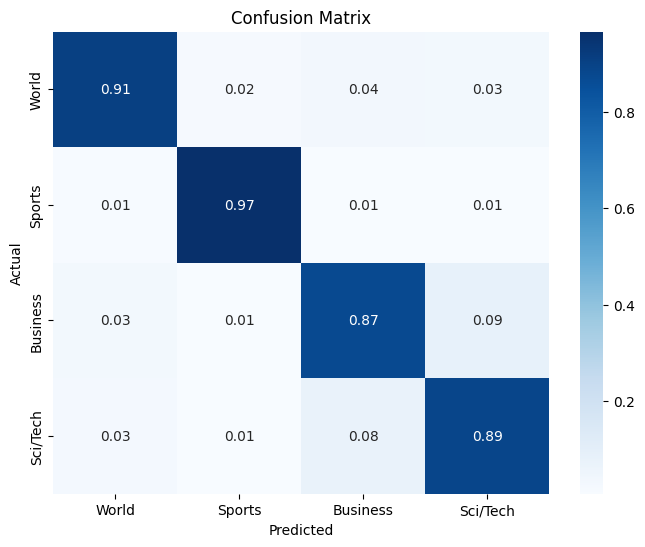

In [89]:
# Plot the confusion matrix
plot_confusion_matrix(cm, labels)

In [90]:
class GRU_Model(nn.Module):
    def __init__(self, embed_size, hidden_size, layers, num_classes, dropout=0.5):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), 
                                            embedding_dim=embed_size)        
        
        self.gru = nn.GRU(embed_size, hidden_size, layers, 
                          batch_first=True, dropout=dropout if layers > 1 else 0)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Ensure input tensor is long type for embedding lookup
        x = x.long()
        
        # Embedding layer output
        embeds = self.embedding_layer(x)
        
        # GRU layer output
        gru_out, hidden = self.gru(embeds)
        
        # Only use the output from the final time step
        last_output = gru_out[:, -1, :]
        
        # Fully connected layer output
        out = self.fc(last_output)
        
        return out


In [91]:
epochs = 20
lr = 1e-3
# instantiate model
gru_model  = GRU_Model(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES, DROPOUT)
gru_model  = gru_model .to(device)
optimiser = torch.optim.AdamW(gru_model .parameters(), lr=lr, weight_decay=1e-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='max', factor=0.1, patience=3, verbose=True)

In [92]:
train(gru_model, train_loader, val_loader, optimiser, scheduler, epochs=20, patience=10)

Epoch 1/20, Loss: 0.6707, Training Accuracy: 89.37, Validation Accuracy: 87.69
Epoch 2/20, Loss: 0.2923, Training Accuracy: 92.61, Validation Accuracy: 89.67
Epoch 3/20, Loss: 0.2144, Training Accuracy: 94.35, Validation Accuracy: 90.36
Epoch 4/20, Loss: 0.1685, Training Accuracy: 95.09, Validation Accuracy: 89.91
Epoch 5/20, Loss: 0.1307, Training Accuracy: 97.06, Validation Accuracy: 91.16
Epoch 6/20, Loss: 0.1034, Training Accuracy: 98.00, Validation Accuracy: 90.74
Epoch 7/20, Loss: 0.0774, Training Accuracy: 98.41, Validation Accuracy: 90.83
Epoch 8/20, Loss: 0.0611, Training Accuracy: 98.56, Validation Accuracy: 90.37
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch 9/20, Loss: 0.0495, Training Accuracy: 99.13, Validation Accuracy: 90.83
Epoch 10/20, Loss: 0.0239, Training Accuracy: 99.55, Validation Accuracy: 91.08
Epoch 11/20, Loss: 0.0176, Training Accuracy: 99.65, Validation Accuracy: 91.15
Epoch 12/20, Loss: 0.0144, Training Accuracy: 99.72, Validation Acc

In [93]:
print(f'{accuracy(gru_model, test_loader):.4f}')

90.9079


In [101]:
# Evaluate the model
true_labels, predictions, cm = evaluate_model(gru_model, test_loader)

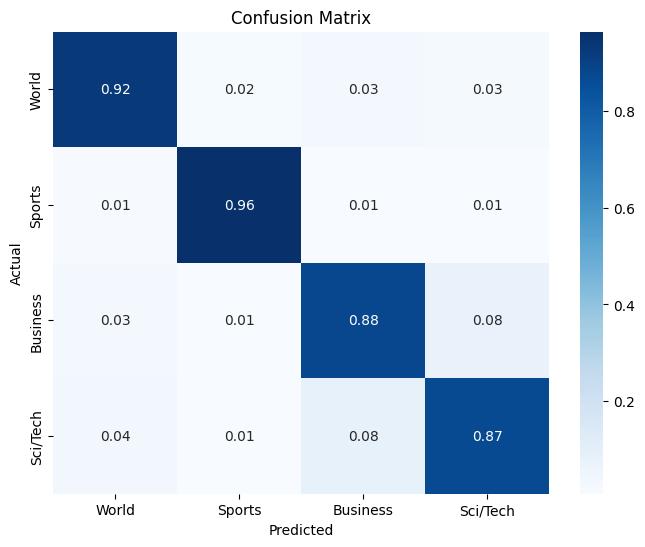

In [102]:
# Plot the confusion matrix
plot_confusion_matrix(cm, labels)

In [118]:
def sample_text(model, text, vocab, tokenizer, max_tokens=50):
    # Ensure model is in evaluation mode
    model.eval()

    # Tokenize and numericalize the text
    tokens = tokenizer(text)
    indices = [vocab[token] for token in tokens]
  
    indices = indices[:max_tokens]

    # Convert to tensor and add batch dimension
    indices_tensor = torch.tensor(indices, dtype=torch.long).unsqueeze(0).to(device)

    # Get the model prediction
    with torch.no_grad():
        output = model(indices_tensor)

    # Convert output probabilities to predicted class
    _, predicted = torch.max(output, 1)
    predicted_class = predicted.item()

    return predicted_class

my_text = "Traders Say UK Inflation Risks Undoing Aggressive Rate-Cut Bets"
predicted_class = sample_text(gru_model, my_text, vocab, tokeniser)
print(f"The predicted class is: {labels[predicted_class]}")


The predicted class is: Business


In [119]:
my_text_2 = "Apple Is Taking Extra Care With ‘Ambitious’ iOS 18 Update"
predicted_class = sample_text(gru_model, my_text_2, vocab, tokeniser)
print(f"The predicted class is: {labels[predicted_class]}")

The predicted class is: Sci/Tech
